In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

import xgboost as xgb

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('/content/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [3]:
df.tail()

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


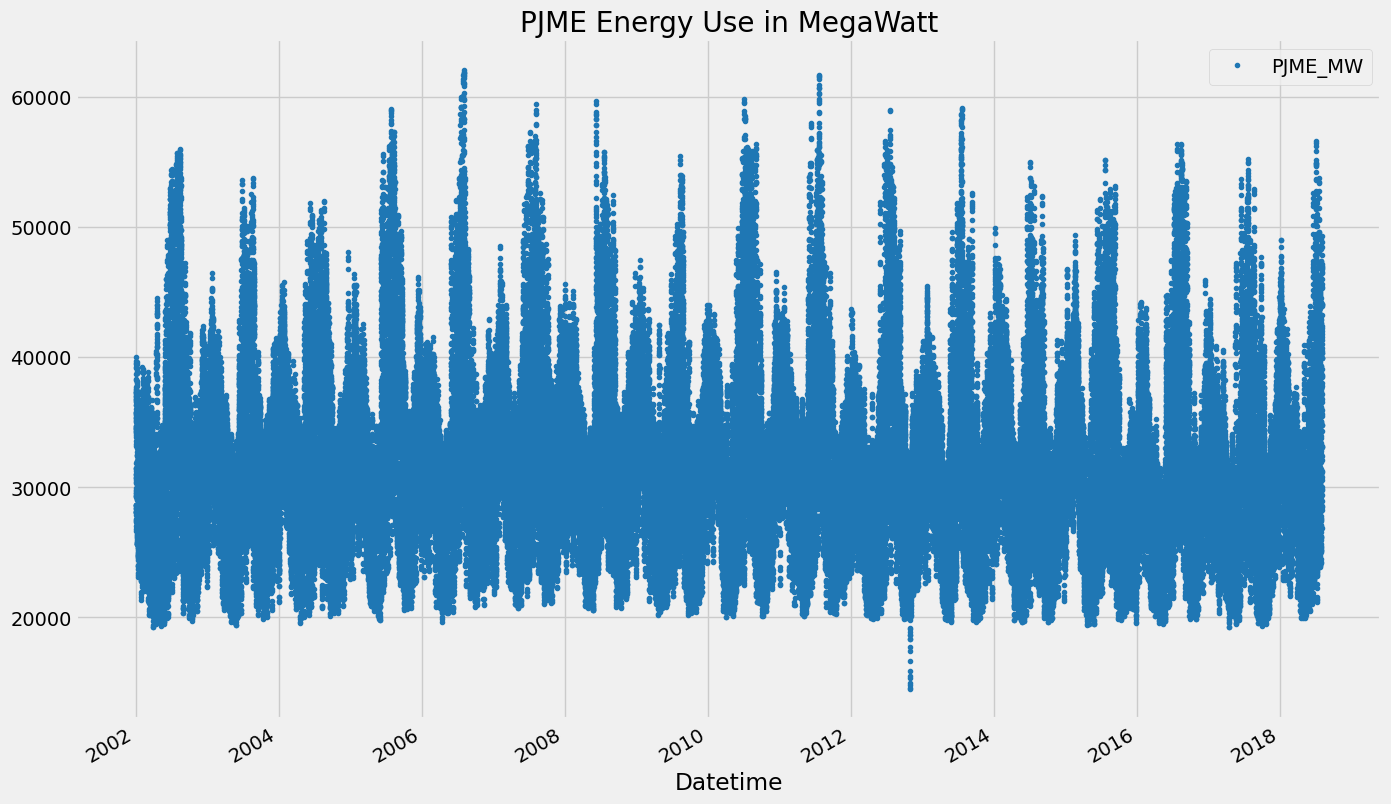

In [4]:
df.plot(style='.',
        figsize=(15,10),
        color=color_pal[0],
        title='PJME Energy Use in MegaWatt')
plt.show()

TRAIN / TEST SPLIT

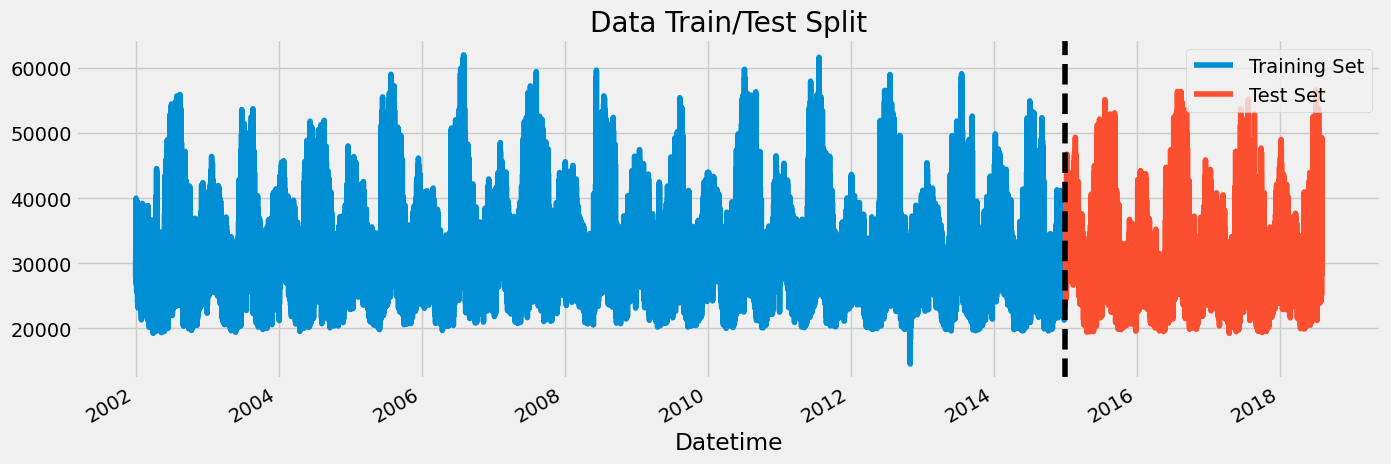

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

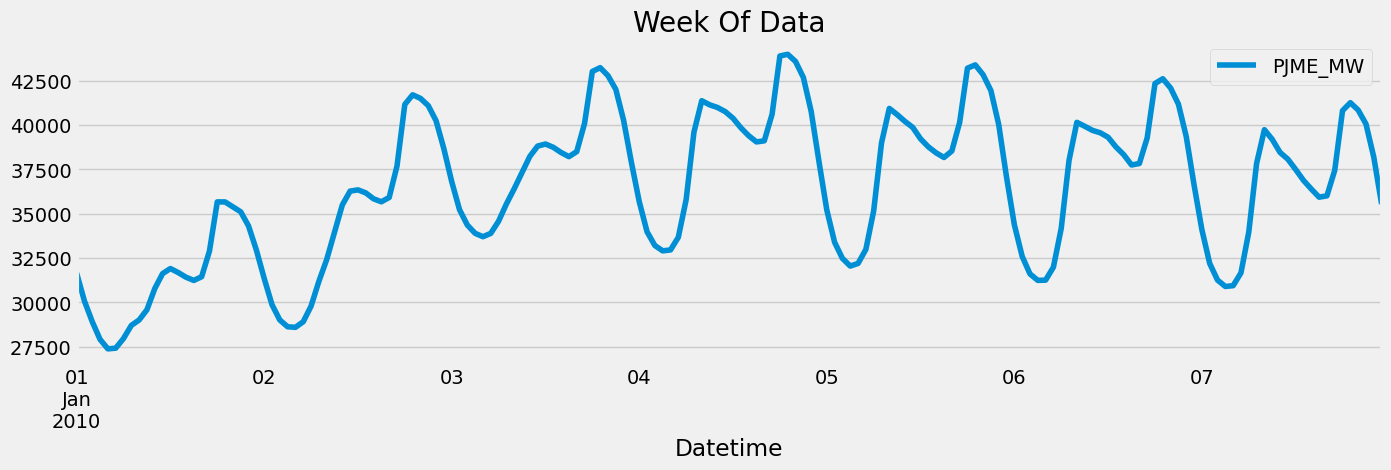

In [6]:
df.index = pd.to_datetime(df.index)

df_filtered = df.loc['2010-01-01':'2010-01-07']

df_filtered.plot(figsize=(15, 4), title='Week Of Data')
plt.show()


## **FEATURE CREATION**


In [7]:
def create_features(df):
  """
  Created time series features based on time series index.

  """
  df = df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter']  = df.index.quarter
  df['month']  = df.index.month
  df['year']  = df.index.year
  df['dayofyear']  = df.index.dayofyear
  return df

df = create_features(df)


##VISUALIZE OUR FEATURE/TARGET RELATIONSHIP##

Text(0.5, 1.0, 'MWatt by Hour')

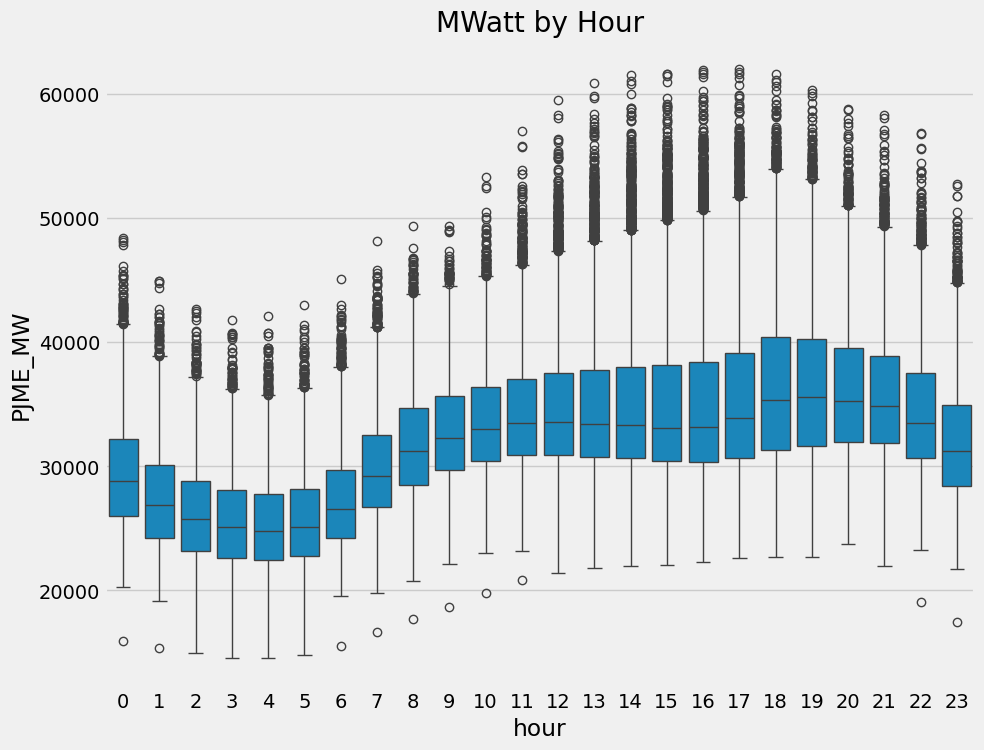

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MWatt by Hour')

<ipython-input-9-6c0084d66a39>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette= 'Accent')


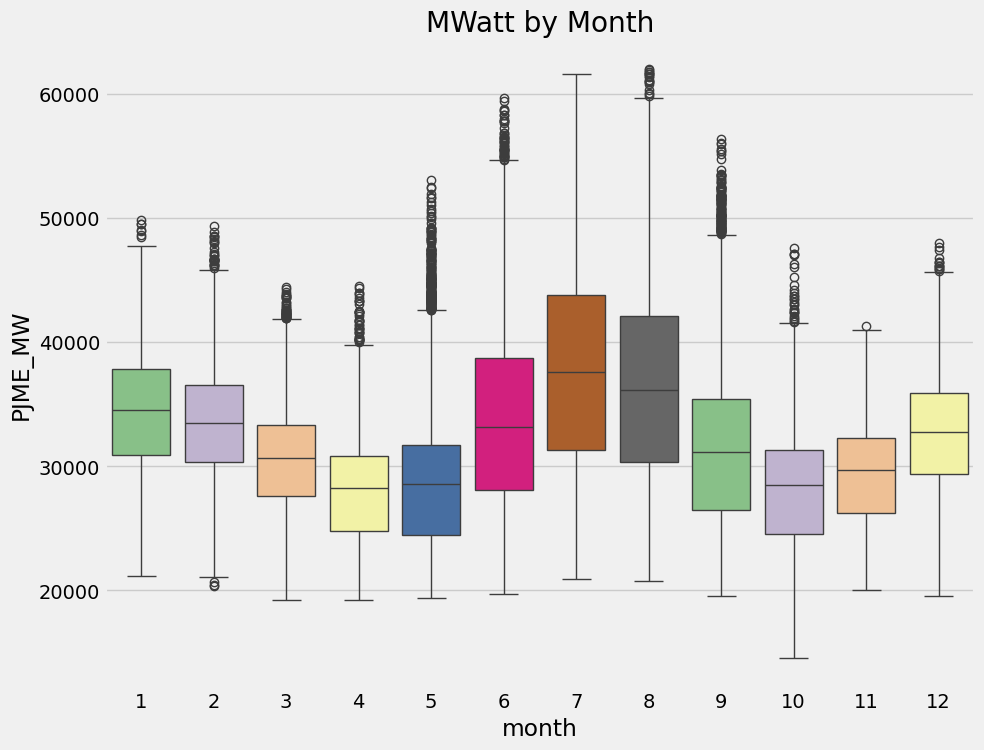

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette= 'Accent')
ax.set_title('MWatt by Month')
plt.show()

#Model building#

In [10]:
train = create_features(train)
test = create_features(test)
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
TARGET = 'PJME_MW'

In [11]:
X_train =  train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [12]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate = 0.02)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=20)

[0]	validation_0-rmse:6362.56868	validation_1-rmse:6438.07082
[20]	validation_0-rmse:4977.82857	validation_1-rmse:5199.84162
[40]	validation_0-rmse:4160.80835	validation_1-rmse:4513.87061
[60]	validation_0-rmse:3690.69576	validation_1-rmse:4150.42569
[80]	validation_0-rmse:3408.79585	validation_1-rmse:3969.15124
[100]	validation_0-rmse:3237.02183	validation_1-rmse:3862.04916
[120]	validation_0-rmse:3116.55401	validation_1-rmse:3786.42053
[140]	validation_0-rmse:3028.01985	validation_1-rmse:3752.24988
[160]	validation_0-rmse:2963.06846	validation_1-rmse:3742.46762
[180]	validation_0-rmse:2909.50574	validation_1-rmse:3736.84039
[200]	validation_0-rmse:2824.69617	validation_1-rmse:3743.88916
[220]	validation_0-rmse:2770.01819	validation_1-rmse:3753.84612
[232]	validation_0-rmse:2739.50877	validation_1-rmse:3767.74201


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##FEATURE IMPORTANCE##

In [13]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
             columns = ['importance'])

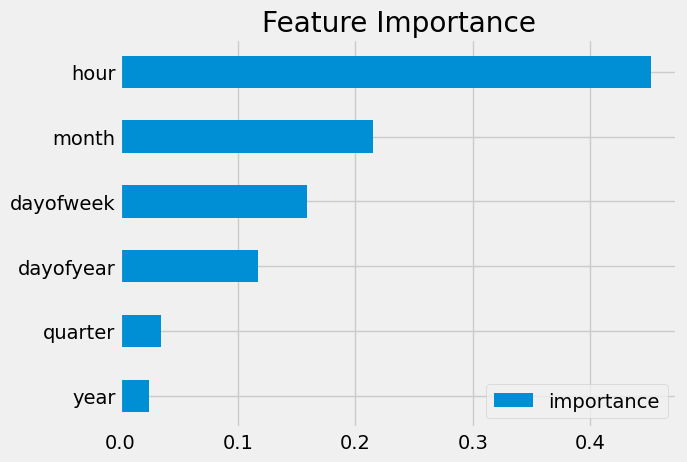

In [14]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

#FORECAST ON TEST#

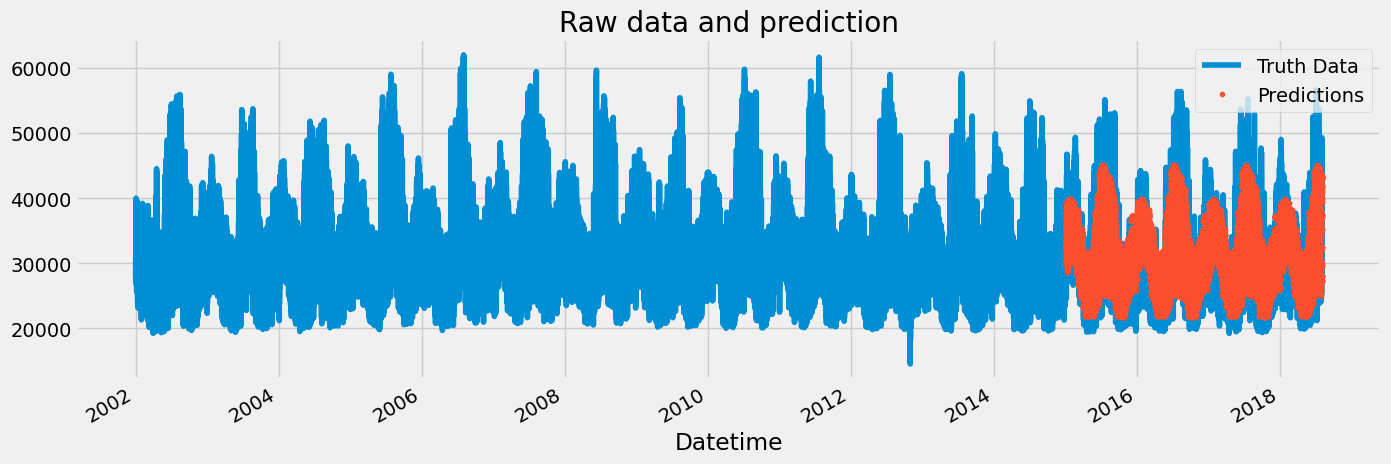

In [15]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test['prediction'], how='left', left_index=True, right_index=True)
ax= df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style = ".")
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw data and prediction')
plt.show()

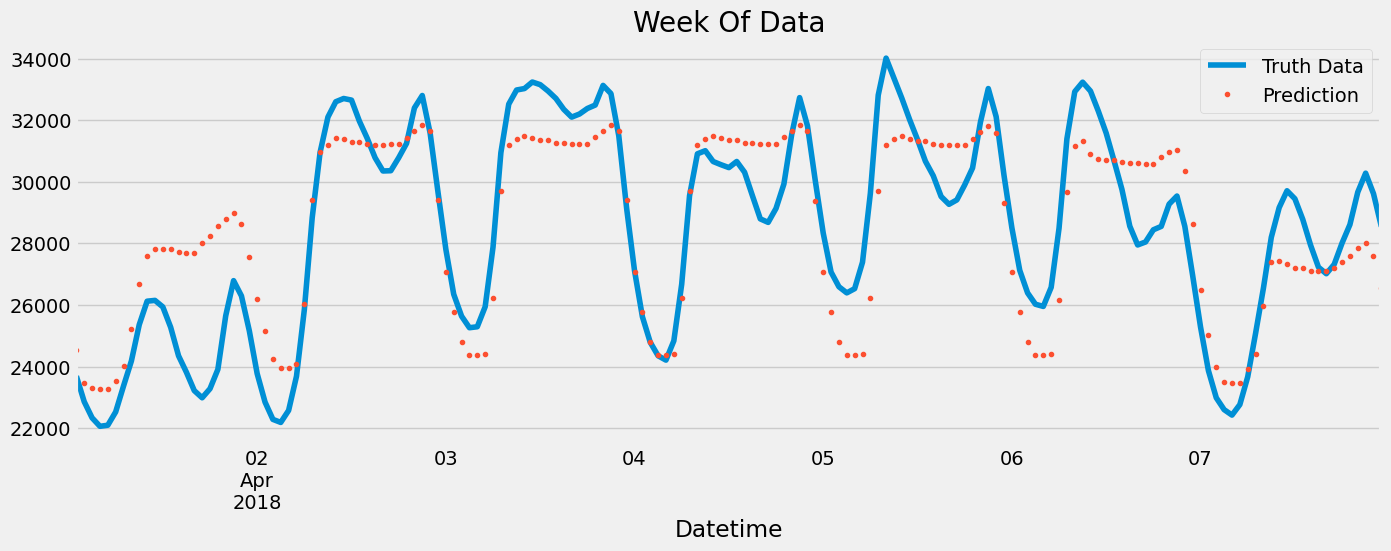

In [16]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

#SCORE(RMSE)#

In [17]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3735.87


#CALCULATE ERROR#

In [18]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

,error
date,
2016-08-13,13648.871419
2016-08-14,13402.263753
2016-09-10,11361.341309
2016-09-09,11217.525228
2016-08-12,10629.900391


In [19]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

,error
date,
2016-12-30,347.509928
2016-10-27,434.697591
2017-10-24,437.385579
2016-04-04,444.382406
2017-05-02,446.451253
